Image Classification Model Deployment


---


*   Nama : Salimah Mahdiyyah
*   Email : salimahdiyyah03@gmail.com
*   Link Dataset : https://www.kaggle.com/datasets/vencerlanz09/reptiles-and-amphibians-image-dataset/data






In [1]:
!pip install kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"salimahmahdiyyah","key":"7e9376375d895fcebb1d18c942efd0fa"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d vencerlanz09/reptiles-and-amphibians-image-dataset -p /content/reptiles

 96% 129M/135M [00:01<00:00, 119MB/s]
100% 135M/135M [00:01<00:00, 120MB/s]


In [5]:
!unzip /content/reptiles/reptiles-and-amphibians-image-dataset.zip -d /content/reptiles

Streaming output truncated to the last 5000 lines.
  inflating: /content/reptiles/Frog/2226997298_9f33ec6960_b.jpg  
  inflating: /content/reptiles/Frog/2286374711_8c3b59d3d2_o.jpg  
  inflating: /content/reptiles/Frog/2287160970_5e594b5506_o.jpg  
  inflating: /content/reptiles/Frog/2287161214_96f61c65c7_o.jpg  
  inflating: /content/reptiles/Frog/2289612412_ab6f55d2c4_o.jpg  
  inflating: /content/reptiles/Frog/22901251346_a4680dee24_o.jpg  
  inflating: /content/reptiles/Frog/2300765529_be02515e22_o.jpg  
  inflating: /content/reptiles/Frog/2330204116_fb7736c7a2_o.jpg  
  inflating: /content/reptiles/Frog/234076549_f7740a5ceb_o.jpg  
  inflating: /content/reptiles/Frog/23422477575_f9691e6b8b_o.jpg  
  inflating: /content/reptiles/Frog/23497613770_ee9e6ea718_o.jpg  
  inflating: /content/reptiles/Frog/2352510812_6cfb4db2a1_o.jpg  
  inflating: /content/reptiles/Frog/23525458_8f9cc5fc0e_o.jpg  
  inflating: /content/reptiles/Frog/23710875861_9cd9273ebd_o.jpg  
  inflating: /content/re

In [6]:
!ls /content/reptiles

Chameleon	     Gecko   reptiles-and-amphibians-image-dataset.zip	Toad
Crocodile_Alligator  Iguana  Salamander					Turtle_Tortoise
Frog		     Lizard  Snake


In [7]:
import os
reptiles = os.path.join('/content/reptiles')
print(os.listdir(reptiles))

['Frog', 'Salamander', 'Chameleon', 'Turtle_Tortoise', 'Crocodile_Alligator', 'Gecko', 'Lizard', 'reptiles-and-amphibians-image-dataset.zip', 'Iguana', 'Snake', 'Toad']


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=20,
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.2)

In [10]:
train_generator = train_datagen.flow_from_directory(
      reptiles,
      target_size=(224, 224),
      batch_size=64,
      classes=['Salamander', 'Lizard', 'Crocodile_Alligator'],
      class_mode='categorical',
      subset='training')
validation_generator = train_datagen.flow_from_directory(
      reptiles,
      target_size=(224, 224),
      batch_size=64,
      classes=['Salamander', 'Lizard', 'Crocodile_Alligator'],
      class_mode='categorical',
      subset='validation')

Found 1342 images belonging to 3 classes.
Found 334 images belonging to 3 classes.


In [16]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input
base_model = VGG16(include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False
base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [20]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

model = tf.keras.models.Sequential([
    base_model,
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [21]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                                 
Total params: 27692355 (105.64 MB)
Trainable params: 129

In [25]:
class myCallback(tf.keras.callbacks.Callback):
   def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy') >= 0.85 and logs.get('val_accuracy') >= 0.85):
          print("\nAkurasi 85%, training end!!")
          self.model.stop_training = True
callbacks = myCallback()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=15, min_lr=0.00001, verbose=2)

In [26]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_generator,
                   validation_data=validation_generator,
                   epochs=500,
                   batch_size=128,
                   callbacks=[callbacks, reduce_lr],
                   steps_per_epoch=5,
                   verbose=2)

Epoch 1/500
5/5 - 11s - loss: 0.4137 - accuracy: 0.8406 - val_loss: 0.4632 - val_accuracy: 0.8323 - lr: 0.0010 - 11s/epoch - 2s/step
Epoch 2/500
5/5 - 10s - loss: 0.4462 - accuracy: 0.8344 - val_loss: 0.4752 - val_accuracy: 0.8144 - lr: 0.0010 - 10s/epoch - 2s/step
Epoch 3/500
5/5 - 11s - loss: 0.4094 - accuracy: 0.8438 - val_loss: 0.4575 - val_accuracy: 0.8353 - lr: 0.0010 - 11s/epoch - 2s/step
Epoch 4/500
5/5 - 11s - loss: 0.4300 - accuracy: 0.8562 - val_loss: 0.4880 - val_accuracy: 0.8263 - lr: 0.0010 - 11s/epoch - 2s/step
Epoch 5/500
5/5 - 11s - loss: 0.4708 - accuracy: 0.8031 - val_loss: 0.4494 - val_accuracy: 0.8383 - lr: 0.0010 - 11s/epoch - 2s/step
Epoch 6/500
5/5 - 14s - loss: 0.5139 - accuracy: 0.8062 - val_loss: 0.4334 - val_accuracy: 0.8533 - lr: 0.0010 - 14s/epoch - 3s/step
Epoch 7/500
5/5 - 11s - loss: 0.3797 - accuracy: 0.8469 - val_loss: 0.4798 - val_accuracy: 0.8353 - lr: 0.0010 - 11s/epoch - 2s/step
Epoch 8/500
5/5 - 12s - loss: 0.5028 - accuracy: 0.8094 - val_loss: 0

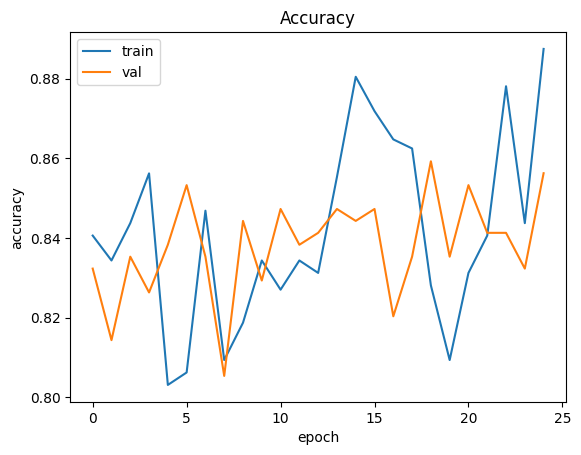

In [27]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

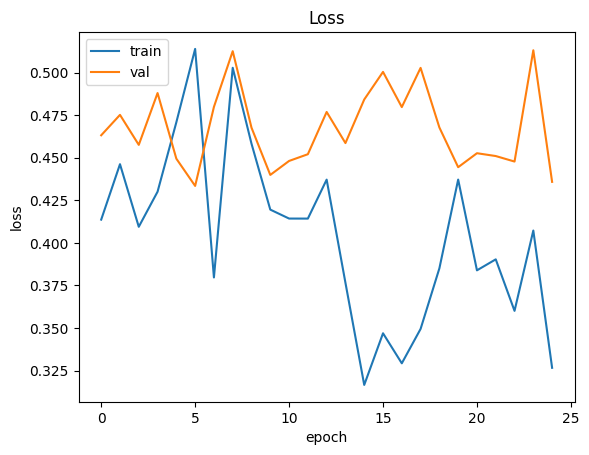

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [30]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [31]:
import pathlib

tflite_model_file = pathlib.Path('reptiles.tflite')
tflite_model_file.write_bytes(tflite_model)

110780256